## Modeling Water Pump Data

In [97]:
#Imports:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

from sklearn import set_config
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer 
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, balanced_accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore') 

#####

In [98]:
df = pd.read_csv('../data/Pump_it_Up_Data_Training_set_values.csv')
target = pd.read_csv('../data/Pump_it_Up_Data_Training_set_labels.csv')
sub_test = pd.read_csv('../data/Pump_it_Up_Data_Test_set_values.csv')

In [99]:
df_joined = pd.concat([df,target], axis=1)

##### General proportions of functional/non funtional/functional needs repair for Iringa:

In [100]:
df_joined[df_joined['region'] == 'Iringa']['status_group'].value_counts(normalize=True)

functional                 0.782206
non functional             0.194560
functional needs repair    0.023234
Name: status_group, dtype: float64

##### DF quick descriptive stats:

In [101]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [102]:
len(target['status_group']), len(df['id'])

(59400, 59400)

#### Baseline Accuracy (54.3%)

In [103]:
df_joined['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

##### Temp split for logreg coef interpretation analysis of numerical features only:

In [104]:
X1 = df_joined.drop(columns = ['basin','region','lga','public_meeting','recorded_by',
                         'scheme_management','permit','extraction_type','management','management_group','payment',
                         'water_quality','quality_group','quantity','source','waterpoint_type','subvillage','installer',
                              'funder','ward','scheme_name','wpt_name','waterpoint_type_group','extraction_type_group',
                              'payment_type','quantity_group','source_type','source_class','extraction_type_class','id', 
                              'status_group' , 'longitude' , 'latitude' , 'date_recorded', 'region_code', 'district_code'])
y1 = df_joined['status_group']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, stratify = y1, random_state=123)

##### Temp LR model for interpretability of numerical features:

In [105]:
lr1 = LogisticRegression(max_iter=10000)
lr1.fit(X_train1,y_train1)
lr1.score(X_train1,y_train1),lr1.score(X_test1,y_test1)

(0.5396857463524131, 0.5451851851851852)

In [106]:
lr1.coef_

array([[ 1.04501428e-04,  1.65809513e-04,  1.04298535e-03,
         1.53629928e-05, -2.93720515e-06],
       [ 7.98957779e-05,  7.57638614e-05, -1.09649406e-03,
         5.34643636e-05, -1.43458570e-04],
       [-1.84397207e-04, -2.41573374e-04,  5.35087085e-05,
        -6.88273564e-05,  1.46395776e-04]])

##### Creating numerical df coefficient dataframe:

In [107]:
numerical_coef_df = pd.DataFrame(np.exp(lr1.coef_).T)
numerical_coef_df['features'] = list(X_train1.columns)
numerical_coef_df = numerical_coef_df.set_index('features')
numerical_coef_df.sort_values(by=[0],ascending=True)

,0,1,2
features,,,
construction_year,0.999997,0.999857,1.000146
population,1.000015,1.000053,0.999931
amount_tsh,1.000105,1.000080,0.999816
gps_height,1.000166,1.000076,0.999758
num_private,1.001044,0.998904,1.000054


#### Partial dependence  plots for exploratory logistic regression model with numerical features only:

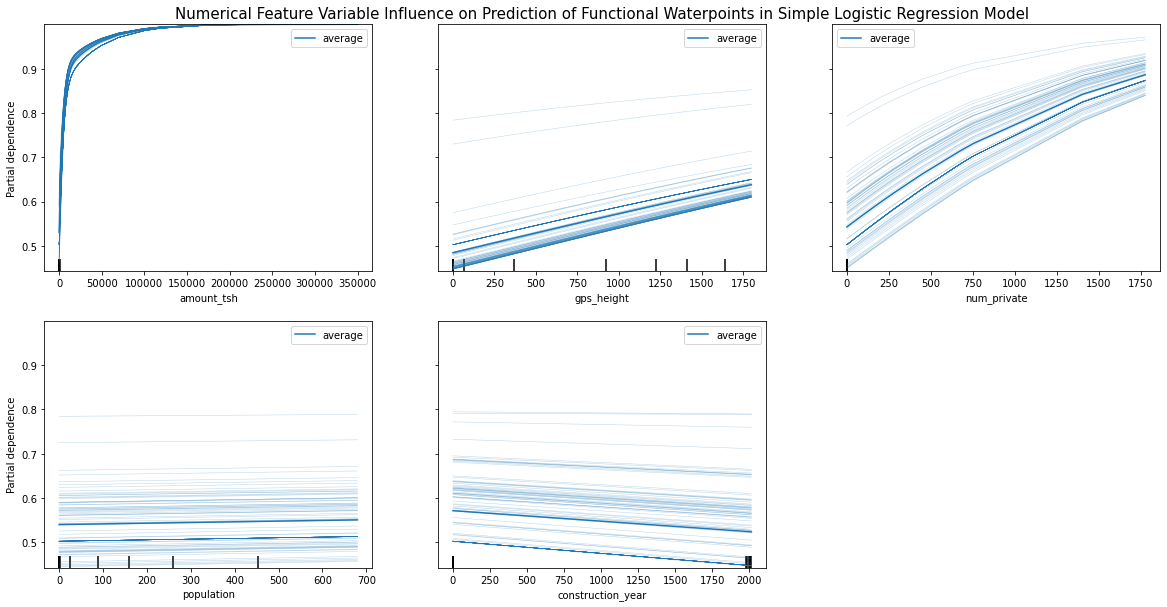

In [108]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Numerical Feature Variable Influence on Prediction of Functional Waterpoints in Simple Logistic Regression Model", fontsize=15)
pdd = PartialDependenceDisplay.from_estimator(lr1, X_train1, target='functional', features=[0,1,2,3,4], subsample=100, kind='both',n_jobs=-1, ax=ax);
plt.savefig('../visualizations/pdd_numeric_func.png', transparent=True, bbox_inches = 'tight')

- This partial dependence plot show that as num_private and a water points gps height increase, so does the likelihood of being a functional well.
- The year of construction appear to negatively correlate with functionality.
- Population has almost no weight on functionality prediction. 

#### Partial dependence  plots for exploratory logistic regression model with numerical features only:

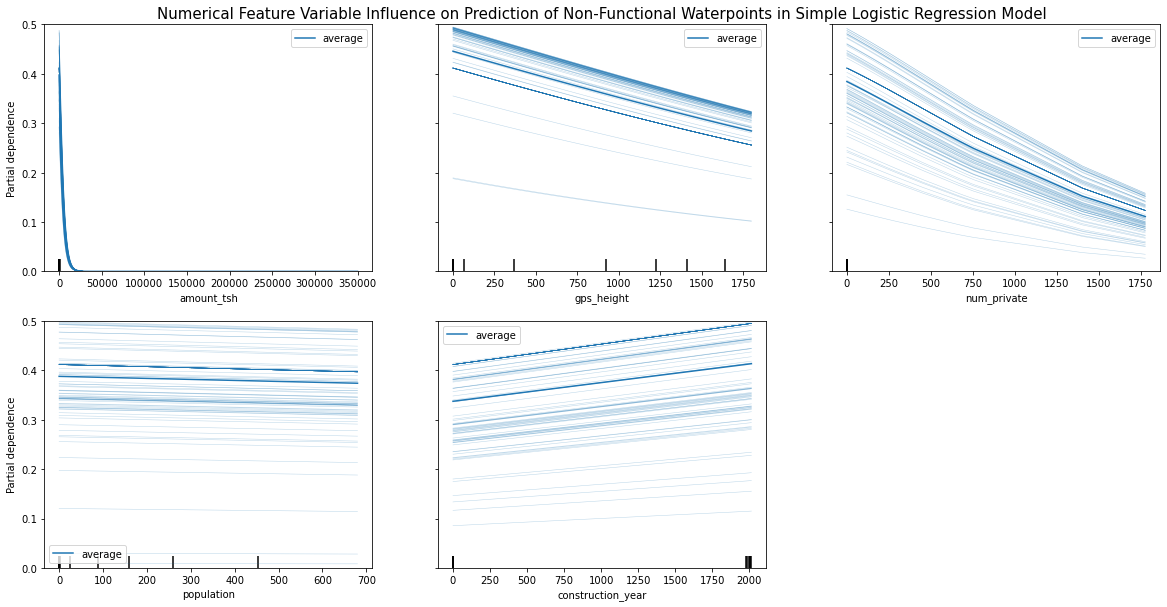

In [109]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Numerical Feature Variable Influence on Prediction of Non-Functional Waterpoints in Simple Logistic Regression Model", fontsize=15)
pdd = PartialDependenceDisplay.from_estimator(lr1, X_train1, target='non functional', features=[0,1,2,3,4], subsample=100, kind='both',n_jobs=-1, ax=ax);
plt.savefig('../visualizations/pdd_numeric_nonfunc.png', transparent=True, bbox_inches = 'tight')

- This partial dependence plot show that as num_private and a water points gps height decrease, so does the likelihood of being a non-functional well.
- The year of construction also appears to positively correlate with non-functionality.
- Population has almost no weight on functionality prediction. 

#### Partial dependence  plots for exploratory logistic regression model with numerical features only:

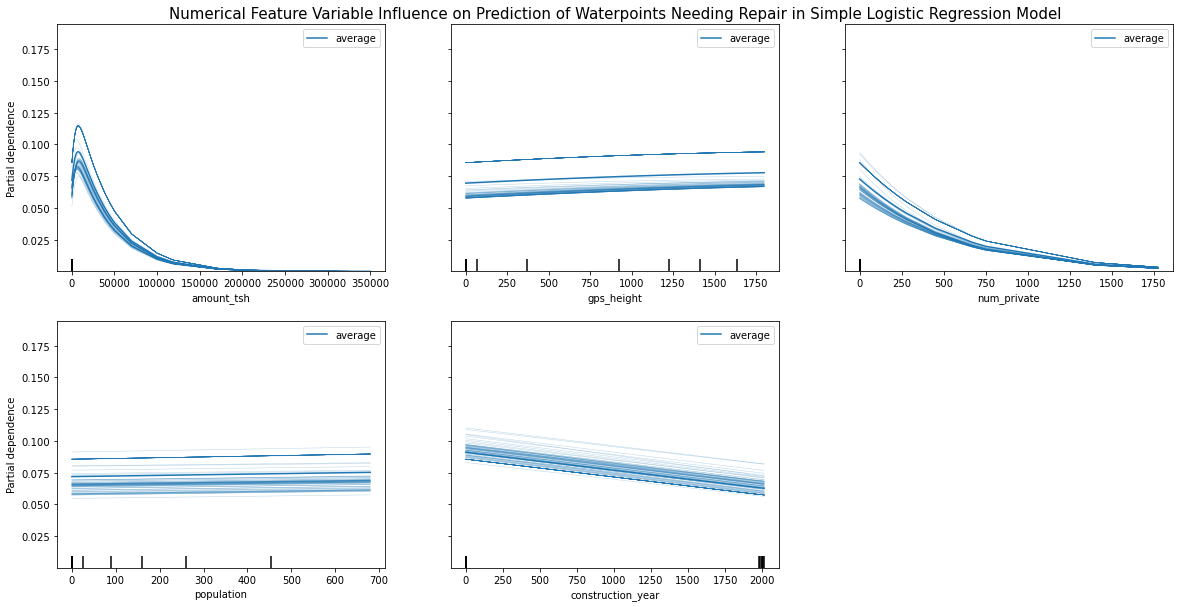

In [110]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Numerical Feature Variable Influence on Prediction of Waterpoints Needing Repair in Simple Logistic Regression Model", fontsize=15)
pdd = PartialDependenceDisplay.from_estimator(lr1, X_train1, target='functional needs repair', features=[0,1,2,3,4], subsample=100, kind='both',n_jobs=-1, ax=ax);
plt.savefig('../visualizations/pdd_numeric_repair.png', transparent=True, bbox_inches = 'tight')

- This partial dependence plot show that as construction year and a water point gps height decreases, so does the likelihood of being a functional water point in need of repair.
- Population and gps height appear to have almost no weight on predicting water points in need of repair. 

#### Temp split for logreg coef interpretation analysis of 251 feature set only:

In [111]:
X = df_joined.drop(columns = ['subvillage','installer','funder','ward','scheme_name','wpt_name','waterpoint_type_group','extraction_type_group','payment_type','quantity_group','source_type','source_class','extraction_type_class','id', 'status_group' , 'longitude' , 'latitude' , 'date_recorded'])
y = df_joined['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=123)

ct1 = ColumnTransformer([('si',SimpleImputer(strategy='constant'),
                          ['public_meeting','scheme_management','permit']),],
                         remainder='passthrough',verbose_feature_names_out = False)            

train_si = ct1.fit_transform(X_train)
train_si = pd.DataFrame(train_si, columns=X_train.columns)
test_si = ct1.transform(X_test)
test_si = pd.DataFrame(test_si, columns=X_test.columns)
sub_test_si = ct1.transform(sub_test)
sub_test_si = pd.DataFrame(sub_test_si, columns=X_test.columns)


ct2 = ColumnTransformer([('ohe',OneHotEncoder(drop='if_binary',handle_unknown='ignore',sparse=False),
                        ['basin','region','lga','public_meeting','recorded_by',
                         'scheme_management','permit','extraction_type','management','management_group','payment',
                         'water_quality','quality_group','quantity','source','waterpoint_type'])],
                         remainder='passthrough',verbose_feature_names_out = False)  


##### Encoding categorical variables for temp interpretation model:

In [112]:
train_enc = ct2.fit_transform(X_train)
train_enc = pd.DataFrame(train_enc, columns = ct2.get_feature_names_out())
test_enc = ct2.transform(X_test)
test_enc = pd.DataFrame(test_enc, columns = ct2.get_feature_names_out())
sub_test_enc = ct2.transform(sub_test)
sub_test_enc = pd.DataFrame(sub_test_enc, columns = ct2.get_feature_names_out())

##### Standard Scaler for temp interpretation model:

In [113]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(train_enc)
X_train_sc = pd.DataFrame(X_train_sc, columns = ss.get_feature_names_out())
X_test_sc = ss.transform(test_enc)
X_test_sc = pd.DataFrame(X_test_sc, columns = ss.get_feature_names_out())
sub_test_sc = ss.transform(sub_test_enc)
sub_test_sc = pd.DataFrame(sub_test_sc, columns = ss.get_feature_names_out())

#### Temp LR model for interpretability of numerical features:

In [114]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_sc,y_train)
lr.score(X_train_sc,y_train),lr.score(X_test_sc,y_test)

(0.753557800224467, 0.7412794612794613)

##### Creating df of categorical coefficient:

In [115]:
coef_df = pd.DataFrame(np.exp(lr.coef_).T)
coef_df['features'] = list(X_train_sc.columns)
coef_df = coef_df.set_index('features')
coef_df.sort_values(by=[1],ascending=False)[:50]

,0,1,2
features,,,
lga_Bariadi,0.886346,1.311796,0.860063
gps_height,1.014485,1.199650,0.821675
lga_Masasi,0.916894,1.173804,0.929148
lga_Ngara,0.987245,1.166874,0.868063
source_river,0.927261,1.161582,0.928428
lga_Bukombe,0.936245,1.160061,0.920725
lga_Dodoma Urban,0.988410,1.155796,0.875350
lga_Mpanda,0.893733,1.145326,0.976929
extraction_type_gravity,0.919669,1.142967,0.951338


##### Code for inspecting this dataframe for most/least weighted coefs:

In [116]:
coef_df.sort_values(by=[1],ascending=True)[:50]

,0,1,2
features,,,
lga_Makete,1.241371,0.684817,1.176315
lga_Hanang,1.155622,0.749461,1.154610
quantity_dry,0.562327,0.759331,2.341962
lga_Kongwa,1.263491,0.761375,1.039512
lga_Muheza,1.198619,0.766388,1.088604
lga_Sengerema,1.133525,0.778539,1.133153
lga_Chato,1.091869,0.780872,1.172869
lga_Bagamoyo,1.144331,0.790276,1.105781
lga_Ilala,1.107109,0.799437,1.129862


#### Partial dependence  plots for exploratory logistic regression model with regions encoded:

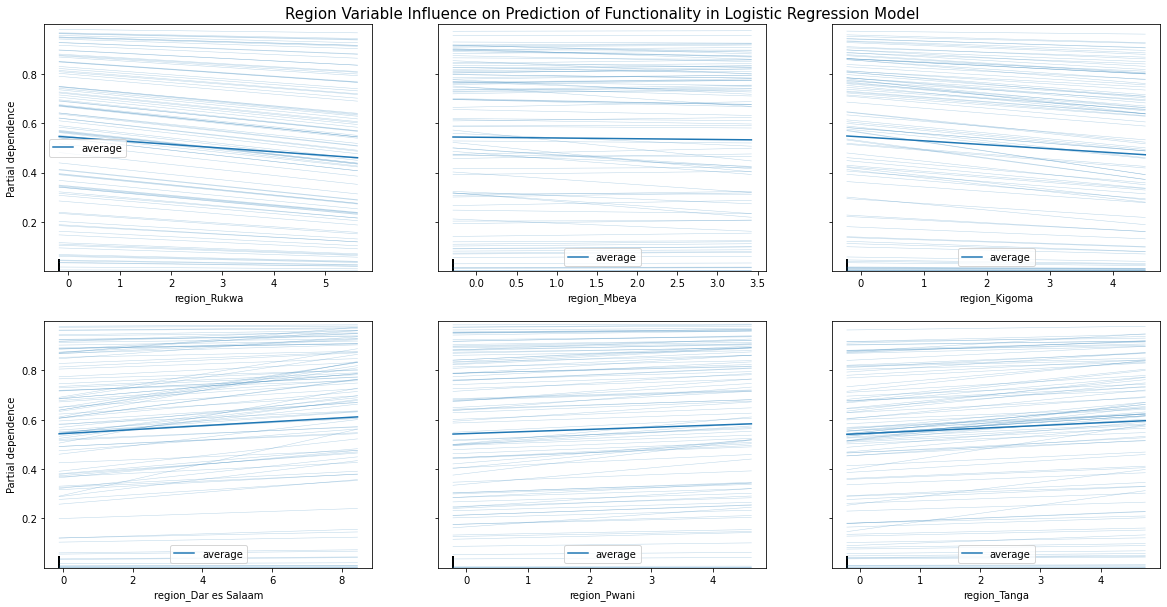

In [117]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Region Variable Influence on Prediction of Functionality in Logistic Regression Model", fontsize=15)
pdd = PartialDependenceDisplay.from_estimator(lr, X_train_sc, target='functional', features=[24,19,14,10, 23, 29], subsample=100, kind='both',n_jobs=-1, ax=ax);
plt.savefig('../visualizations/pdd_region_func.png', transparent=True, bbox_inches = 'tight')

- This plot singles out encoded region variables with the largest and smallest precipitation ranges from year to year. 
- Regions with less range of precipitation show negative correlation with functionality.
- Regions with more range of precipitation show positive correlation with functionality.

#### Searching for best model:

In [118]:
X2 = df_joined.drop(columns = ['permit','subvillage','funder','wpt_name','waterpoint_type_group','extraction_type_group',
                               'payment_type','quantity_group','source_type','source_class','extraction_type_class','id',
                               'status_group' , 'longitude' , 'latitude' , 'date_recorded'])
y2 = df_joined['status_group']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify = y, random_state=123)

ct1_1 = ColumnTransformer([('si',SimpleImputer(strategy='constant'),
                          ['public_meeting','scheme_management','scheme_name','installer']),],
                         remainder='passthrough',verbose_feature_names_out = False)  
        
train_si2 = ct1_1.fit_transform(X_train2)
train_si2 = pd.DataFrame(train_si2, columns=['public_meeting','scheme_management','scheme_name','installer',
                                             'amount_tsh', 'gps_height', 'num_private', 'basin',
                                           'region', 'region_code', 'district_code', 'lga', 'ward', 'population',
                                            'recorded_by', 'construction_year', 'extraction_type', 'management',
                                            'management_group', 'payment', 'water_quality', 'quality_group',
                                               'quantity', 'source', 'waterpoint_type'])
test_si2 = ct1_1.transform(X_test2)
test_si2 = pd.DataFrame(test_si2, columns=['public_meeting','scheme_management','scheme_name','installer',
                                             'amount_tsh', 'gps_height', 'num_private', 'basin',
                                           'region', 'region_code', 'district_code', 'lga', 'ward', 'population',
                                            'recorded_by', 'construction_year', 'extraction_type', 'management',
                                            'management_group', 'payment', 'water_quality', 'quality_group',
                                               'quantity', 'source', 'waterpoint_type'])

ct2_2 = ColumnTransformer([('ohe',OneHotEncoder(drop='if_binary',handle_unknown='ignore',sparse=False),
                        ['basin','region','lga','ward','public_meeting','recorded_by','scheme_name','installer',
                         'scheme_management','extraction_type','management','management_group','payment',
                         'water_quality','quality_group','quantity','source','waterpoint_type'])],
                         remainder='passthrough',verbose_feature_names_out = False) 

##### Encoding train/test to find best model:

In [119]:
train_enc2 = ct2_2.fit(X_train2)
train_enc2 = pd.DataFrame(ct2_2.transform(X_train2))
test_enc2 = pd.DataFrame(ct2_2.transform(X_test2))

##### Encoding submission test set to find best model:

In [120]:
sub_test_enc2 = ct2_2.transform(sub_test)
sub_test_enc2 = pd.DataFrame(sub_test_enc2, columns = ct2_2.get_feature_names_out())

##### Standard Scaling train/test to find best model:

In [121]:
ss2 = StandardScaler()
X_train_sc2 = ss.fit_transform(train_enc2)
X_train_sc2 = pd.DataFrame(X_train_sc2)
X_test_sc2 = ss.transform(test_enc2)
X_test_sc2 = pd.DataFrame(X_test_sc2)

##### Standard Scaling submission test set to find best model:

In [122]:
sub_test_sc2 = ss.transform(sub_test_enc2)
sub_test_sc2 = pd.DataFrame(sub_test_sc2)

#### Best performing model 1 for submission attempt:

In [123]:
rfc = RandomForestClassifier()
rfc.fit(X_train_sc,y_train)
rfc.score(X_train_sc,y_train),rfc.score(X_test_sc,y_test)

(0.944354657687991, 0.7857239057239057)

#### Best performing model 2 for submission attempt:

In [124]:
rfc2 = RandomForestClassifier()
rfc2.fit(X_train_sc2,y_train)
rfc2.score(X_train_sc2,y_train),rfc2.score(X_test_sc2,y_test)

(0.9669809203142536, 0.7919191919191919)

#### Preparing and saving submission 1:

In [125]:
sub_preds = rfc.predict(sub_test_sc)
submission = pd.DataFrame()
submission.index = sub_test['id'].copy()
submission['status_group'] = sub_preds
submission
submission.to_csv('../submissions/submission_01.csv')

#### Preparing and saving submission 2:

In [126]:
sub_preds2 = rfc2.predict(sub_test_sc2)
submission2 = pd.DataFrame()
submission2.index = sub_test['id'].copy()
submission2['status_group'] = sub_preds2
submission2.to_csv('../submissions/submission_02.csv')

### Trying More Models

In [127]:
X = pd.read_csv('../data/Pump_it_Up_Data_Training_set_values.csv')
y = pd.read_csv("../data/Pump_it_Up_Data_Training_set_labels.csv")
X.shape, y.shape

((59400, 40), (59400, 2))

In [128]:
y = y["status_group"]

In [129]:
X["datetime_recorded"] = pd.to_datetime(X["date_recorded"])
#356 different values

In [130]:
X["datetime_recorded"].dt.year.value_counts()

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: datetime_recorded, dtype: int64

In [131]:
X["year_month_recorded"] = X["datetime_recorded"].dt.to_period('M').dt.strftime("%Y-%m")
#keep only year and month
#reduce to 38 different values

In [132]:
#w/out date_recorded, less features, run faster, acc = 74.8%
cat_feats = ["region",
             "lga",
             "public_meeting",
             "scheme_management",
             "permit",
             "extraction_type",
             "management",
             "payment_type",
             "water_quality",
             "quantity_group",
             "source",
             "waterpoint_type",
             "date_recorded"]

In [133]:
X_cat = X[cat_feats]
X_cat.isna().sum()

region                  0
lga                     0
public_meeting       3334
scheme_management    3877
permit               3056
extraction_type         0
management              0
payment_type            0
water_quality           0
quantity_group          0
source                  0
waterpoint_type         0
date_recorded           0
dtype: int64

In [134]:
X_cat.shape

(59400, 13)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, random_state=42, stratify=y)

#### Logistic Regression

> ##### SimpleImputer

In [136]:
ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe1 = Pipeline([("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe1.fit(X_train, y_train)
pipe1.score(X_train, y_train).round(3), pipe1.score(X_test, y_test).round(3)

(0.756, 0.753)

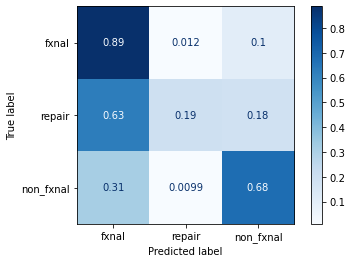

In [137]:
ConfusionMatrixDisplay.from_estimator(pipe1,
                                      X_train,
                                      y_train,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

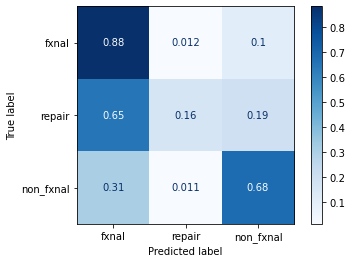

In [138]:
ConfusionMatrixDisplay.from_estimator(pipe1,
                                      X_test,
                                      y_test,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

> Poor performance on the "repair" class
>
> Maybe use techniques for imbalanced data

##### KNNImputer (Same Performance as SimpleImputer)

In [139]:
ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

knn_imputer = KNNImputer(n_neighbors=15)

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe2 = Pipeline([("ohe", mct), ("impu", knn_imputer), ("sc", ss), ("clf", logreg)])

pipe2.fit(X_train, y_train)
pipe2.score(X_train, y_train).round(3), pipe2.score(X_test, y_test).round(3)

(0.756, 0.753)

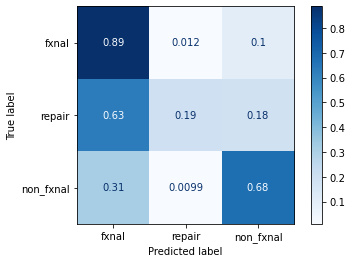

In [140]:
ConfusionMatrixDisplay.from_estimator(pipe2,
                                      X_train,
                                      y_train,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

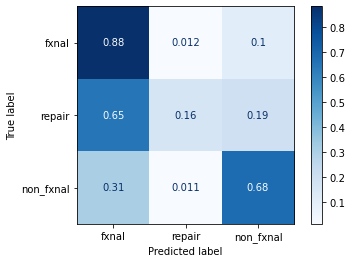

In [141]:
ConfusionMatrixDisplay.from_estimator(pipe2,
                                      X_test,
                                      y_test,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

##### Include 9 Numeric Features (No Difference)

In [142]:
num_feats = list(X.select_dtypes(include = "number").drop(columns = ["id"]).columns)
#list of numeric features

In [143]:
X_num_cat = X[num_feats + cat_feats]

In [144]:
X_num_cat.shape

(59400, 22)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, random_state=42, stratify=y)

In [146]:
ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe3 = Pipeline([("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe3.fit(X_train, y_train)
pipe3.score(X_train, y_train).round(3), pipe3.score(X_test, y_test).round(3)

(0.756, 0.753)

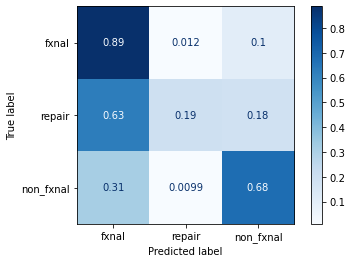

In [147]:
ConfusionMatrixDisplay.from_estimator(pipe3,
                                      X_train,
                                      y_train,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

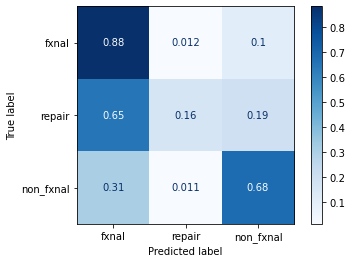

In [148]:
ConfusionMatrixDisplay.from_estimator(pipe3,
                                      X_test,
                                      y_test,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

> The 9 numeric features are not useful for prediction

#### Modeling with Imbalanced Data

In [149]:
cat_feats = ["region",
             "lga",
             "public_meeting",
             "scheme_management",
             "permit",
             "extraction_type",
             "management",
             "payment_type",
             "water_quality",
             "quantity_group",
             "source",
             "waterpoint_type"]

In [150]:
X_cat = X[cat_feats]
X_cat.isna().sum()

region                  0
lga                     0
public_meeting       3334
scheme_management    3877
permit               3056
extraction_type         0
management              0
payment_type            0
water_quality           0
quantity_group          0
source                  0
waterpoint_type         0
dtype: int64

In [151]:
X_cat.shape

(59400, 12)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, random_state=42, stratify=y)

#### Oversampling to Fully Balanced Data

In [153]:
#Over sampling to make all classes have the same population. This is extreme.
ros = RandomOverSampler(random_state=42,
                        sampling_strategy="not majority")

ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe5 = ImbPipeline([ ("ros", ros), ("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

# gs5 = GridSearchCV(pipe5,
#                    {"ros__sampling_strategy": [0.25, 0.5, 0.75, 1.0]},
#                    scoring="balanced_accuracy", 
#                    n_jobs=-1)
# gs5.fit(X_train, y_train)

pipe5.fit(X_train, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='not majority')),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit', 'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_quality',
              

In [154]:
pipe5.score(X_train, y_train).round(3), pipe5.score(X_test, y_test).round(3)

(0.651, 0.652)

In [155]:
balanced_accuracy_score(y_test, pipe5.predict(X_test)).round(3)

0.665

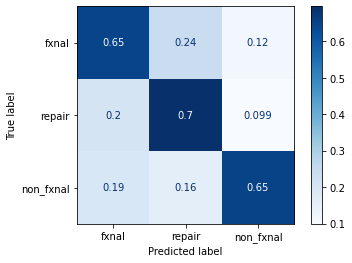

In [156]:
ConfusionMatrixDisplay.from_estimator(pipe5,
                                      X_test,
                                      y_test,
                                      cmap="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize = "true");

In [157]:
y_train.value_counts()

functional                 24194
non functional             17118
functional needs repair     3238
Name: status_group, dtype: int64

#### Oversample the Least Populated Class to 10,000 Observations 

In [158]:
#resample the least populated class (funtional needs repair) to 10_000 observations (up from 3_238)
ros = RandomOverSampler(random_state=42,
                        sampling_strategy={"functional needs repair": 10_000})

ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe6 = ImbPipeline([ ("ros", ros), ("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe6.fit(X_train, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy={'functional needs repair': 10000})),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit', 'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_qual

In [159]:
pipe6.score(X_train, y_train).round(3), pipe6.score(X_test, y_test).round(3)

(0.723, 0.723)

In [160]:
balanced_accuracy_score(y_test, pipe6.predict(X_test)).round(3)

0.631

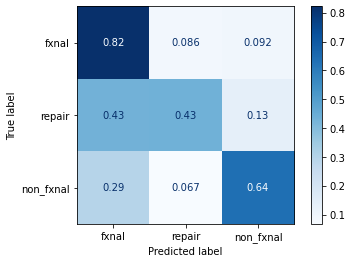

In [161]:
ConfusionMatrixDisplay.from_estimator(pipe6,
                                      X_test,
                                      y_test,
                                      cmap="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize = "true");

#### Oversample the Least Populated Class to 15,000 Observations 

In [162]:
#resample the least populated class (funtional needs repair) to 15_000 observations (up from 3_238)
ros = RandomOverSampler(random_state=42,
                        sampling_strategy={"functional needs repair": 15_000})

ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe7 = ImbPipeline([ ("ros", ros), ("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe7.fit(X_train, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy={'functional needs repair': 15000})),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit', 'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_qual

In [163]:
pipe7.score(X_train, y_train).round(3), pipe7.score(X_test, y_test).round(3)

(0.693, 0.697)

In [164]:
balanced_accuracy_score(y_test, pipe7.predict(X_test)).round(3)

0.658

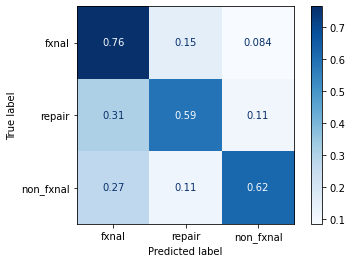

In [165]:
ConfusionMatrixDisplay.from_estimator(pipe7,
                                      X_test,
                                      y_test,
                                      cmap="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize = "true");

#### Oversample the Least Populated Class to 20,000 Observations 

In [166]:
#resample the least populated class (funtional needs repair) to 20_000 observations (up from 3_238)
ros = RandomOverSampler(random_state=42,
                        sampling_strategy={"functional needs repair": 20_000})

ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe8 = ImbPipeline([ ("ros", ros), ("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe8.fit(X_train, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy={'functional needs repair': 20000})),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit', 'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_qual

In [167]:
pipe8.score(X_train, y_train).round(3), pipe8.score(X_test, y_test).round(3)

(0.664, 0.667)

In [168]:
balanced_accuracy_score(y_test, pipe8.predict(X_test)).round(3)

0.663

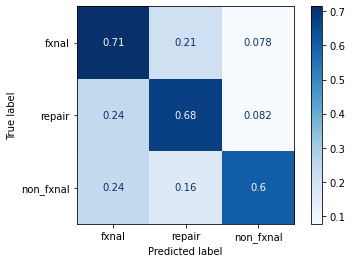

In [169]:
ConfusionMatrixDisplay.from_estimator(pipe8,
                                      X_test,
                                      y_test,
                                      cmap="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize = "true");

## Conclusions and Recommendations

Our best model used a Random Forest Classifier on all numerical features and all categorical features encoded except for a few features like "permit", "subvillage", and "funder". The excluded features, when individually included, showed no increase in model performance and often caused feature bloat beyond what any transformer or estimator could handle. Features were standard scaled and the default hyperparameters of the random forest classifier performed best with an accuracy score of approximately 79%.

There is no “one size fits all” approach to the needs of Tanzania.

Some regions have much more water availability as precipitation than others while some regions have greater variance from year to year in precipitation than others. Different regions have different infrastuctural demands and capacityies and all of this is pretty dynamic from year to year given all of the non-profit intervention in the area. 

Information is very hard to come by in this region. Information is often incomplete or incongruous, but with the aduncance of data that we were able to dig up, we can confidently recommend that more information, better information collection practice, and greater information transparency in combination with predictive models CAN lead to the greatest improvements in living conditions in Tanzania. 

Since the nature and needs of Tanzania can be so dynamic,  predictive modeling and information transparency can be the best tools for saving lives. 

For this reason we produded an app. This app can be used by on the ground non-profit workers to pay closer attention to dynamic trends in climatological and infrastructural data as it pertains to Tanzania region by region. Accessibility and transparency of information will be key to improving the lives of Tanzanians.